In [1]:
import numpy as np
# from helper import *
# from helper_dep import *
# from helper_indep import *
# from helper_shapley_sampling import *
# from helper_kshap import *
import matplotlib.pyplot as plt
import pickle

import sage
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

/Users/jeremygoldwasser/opt/anaconda3/envs/shap/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# "Success" column is output
df_orig = sage.datasets.bank()
df_orig.columns = df_orig.columns.str.replace(' ', '_')
feature_names = df_orig.columns.tolist()[:-1]
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev_Outcome']
categorical_inds = [feature_names.index(col) for col in categorical_cols]
df_orig

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Prev_Days,Prev_Contacts,Prev_Outcome,Success
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,False
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,False
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,False
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,False
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,True
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,True
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,True
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,False


In [3]:
# Change to binary so we can use sklearn classifiers. gradient boosting produces 0 derivatives so don't want to use
n_levels = [len(df_orig[col].unique()) for col in categorical_cols]
print(n_levels)
for col in df_orig:
    if col in categorical_cols:
        print(col)
        print(df_orig[col].unique())

[12, 3, 4, 2, 2, 2, 3, 12, 4]
Job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Marital
['married' 'single' 'divorced']
Education
['tertiary' 'secondary' 'unknown' 'primary']
Default
['no' 'yes']
Housing
['yes' 'no']
Loan
['no' 'yes']
Contact
['unknown' 'cellular' 'telephone']
Month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Prev_Outcome
['unknown' 'failure' 'other' 'success']


In [4]:
# Change columns to binary
df = df_orig.copy()
jobs = pd.get_dummies(df.Job, prefix='Job')
df = df.join(jobs)
df.drop(['Job'], axis=1, inplace=True)

marital = pd.get_dummies(df.Marital, prefix='Marital')
df = df.join(marital)
df.drop(['Marital'], axis=1, inplace=True)

Education = pd.get_dummies(df.Education, prefix='Education')
df = df.join(Education)
df.drop(['Education'], axis=1, inplace=True)

Contact = pd.get_dummies(df.Contact, prefix='Contact')
df = df.join(Contact)
df.drop(['Contact'], axis=1, inplace=True)

Month = pd.get_dummies(df.Month, prefix='Month')
df = df.join(Month)
df.drop(['Month'], axis=1, inplace=True)

prev_outcome = pd.get_dummies(df["Prev_Outcome"], prefix='Prev_Outcome')
df = df.join(prev_outcome)
df.drop(['Prev_Outcome'], axis=1, inplace=True)

df.Default = df.Default.map({'no': 0, 'yes': 1})
df.Housing = df.Housing.map({'no': 0, 'yes': 1})
df.Loan = df.Loan.map({'no': 0, 'yes': 1})




In [5]:
df

,Age,Default,Balance,Housing,Loan,Day,Duration,Campaign,Prev_Days,Prev_Contacts,...,Month_jun,Month_mar,Month_may,Month_nov,Month_oct,Month_sep,Prev_Outcome_failure,Prev_Outcome_other,Prev_Outcome_success,Prev_Outcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,456,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,1127,5,184,3,...,0,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,508,4,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
# Y_train = train[:, -1].copy().astype(int)
# Y_val = val[:, -1].copy().astype(int)
# Y_test = test[:, -1].copy().astype(int)
# train = train[:, :-1].copy()
# val = val[:, :-1].copy()
# test = test[:, :-1].copy()

suc_idx = df.columns.get_loc("Success")
Y_train = train[:, suc_idx].copy().astype(int)
Y_val = val[:, suc_idx].copy().astype(int)
Y_test = test[:, suc_idx].copy().astype(int)
X_train = np.delete(train, suc_idx, axis=1).astype("float64")
X_val = np.delete(val, suc_idx, axis=1).astype("float64")
X_test = np.delete(test, suc_idx, axis=1).astype("float64")

n_train, d_binarized = X_train.shape
d_orig = len(feature_names)
d_orig

# X_train is a np array with no labels, but it mostly aligns with df
# The only difference is that df has the target column with index suc_idx
X_df = df.copy()
X_df.drop(['Success'], axis=1, inplace=True)

In [7]:
# make vector listing type of each columnn (ignoring binary structure)
types = [None]*d_orig
for j in range(d_orig):
    if j in categorical_inds:
        idx_in_categorical_inds = np.argwhere(np.array(categorical_inds)==j).item()
        n_lev = n_levels[idx_in_categorical_inds]
        if n_lev==2:
            types[j] = "binary"
        else:
            types[j] = "multilevel"
    else:
        unique_vals = np.unique(X_train[:,j]).astype(float)
        vals_minus_int = unique_vals - np.round(unique_vals)
        is_not_ordinal = np.sum(vals_minus_int != 0)
        if is_not_ordinal:
            types[j] = "continuous"
        else:
            types[j] = "ordinal"

types_dict = {}
for i in range(len(feature_names)):
    types_dict.update({feature_names[i]: types[i]})
types_dict



{'Age': 'ordinal',
 'Job': 'multilevel',
 'Marital': 'multilevel',
 'Education': 'multilevel',
 'Default': 'binary',
 'Balance': 'ordinal',
 'Housing': 'binary',
 'Loan': 'binary',
 'Contact': 'multilevel',
 'Day': 'ordinal',
 'Month': 'multilevel',
 'Duration': 'ordinal',
 'Campaign': 'ordinal',
 'Prev_Days': 'ordinal',
 'Prev_Contacts': 'ordinal',
 'Prev_Outcome': 'multilevel'}

## Fitting model

Original model is gradient tree boosting. Trees have flat gradients locally, though, so it's harder to choose hyperparameters that will yield a nonzero gradient. For now, then, focusing on models that aren't piecewise. sklearn requires categorical features to be encoded as binary, which is why we do the whole annoying one-hot encoding schema.<br>

Specifically, looking at logistic regression. This works even when the matrix has binary columns for each variable
and thus is not full-rank… I think this is because it fits without an intercept term<br>


In [439]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000).fit(X_train, Y_train)
print(X_train.shape[1], model.coef_.shape)
model.predict_proba(X_test)
# from sklearn.neural_network import MLPClassifier
# model = MLPClassifier().fit(X_train, Y_train)
# Also tried running w neural network & it seems to work

48 (1, 48)


array([[0.96098469, 0.03901531],
       [0.95188175, 0.04811825],
       [0.84721359, 0.15278641],
       ...,
       [0.24673047, 0.75326953],
       [0.94507287, 0.05492713],
       [0.94877249, 0.05122751]])

In [9]:
# Overall good! but model messes up on test set index 0, so set index 1 as xloc.
print("Classification test-set accuracy, Logistic regression: {}".format(np.mean(model.predict(X_test)==Y_test)))
for i in range(2):
    print(Y_test[i]==model.predict(X_test[i].reshape((1,-1))))


Classification test-set accuracy, Logistic regression: 0.900464499004645
[False]
[ True]


## First & Second Derivatives w.r.t. ordinal feature
### First derivative

In [56]:
# Right off the bat, compute the true gradient and Hessian of our logistic regression model
xloc = X_test[1].reshape((1,-1))
gradient = grad_at_xloc(xloc, model.coef_.reshape(-1))
H = hessian(xloc, model.coef_.reshape(-1))

In [431]:
# Package doesn't work here
import numdifftools as nd
def model_prob(x):
    return model.predict_proba(xloc)[0,1]
H_package = nd.Hessian(model_prob)(xloc.reshape(-1))
print(np.max(H_package))
grad_package = nd.Gradient(model_prob)(xloc.reshape(-1))
print(np.max(grad_package))

0.0
0.0


(48,)

In [57]:
# Identify j = index of an ordinal column in X_train/X_test/xloc 
for col in df_orig.columns:
    if types_dict[col]=="ordinal":
        ordinal_colname = col
        print(ordinal_colname)
        break
# Find index of this column in X_df, and thus X_train
j = np.nonzero(X_df.columns==ordinal_colname)[0].item()
print(j, ordinal_colname)

Age
0 Age


In [58]:
Ks = [10000, 1000, 100, 10] # Very stable wrt K here
n_equal = np.sum(X_train[:,j] == xloc[0,j])
idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))

for K in Ks:
    # Find indices of K rows of X whose j'th column is closest - but not zero - to xloc's.
    idx = idx_dists_ordered[n_equal:(n_equal+K)]
    xj_vals = X_train[idx, j]
    values, counts = np.unique(xj_vals, return_counts=True)
    der_ests = [0]*len(values)
    for i in range(len(values)):
        h = values[i] - xloc[0][j]
        xloc_plus_h = np.copy(xloc)
        xloc_plus_h[0][j] += h
        der_ests[i] = (model.predict_proba(xloc_plus_h)[0,1] - model.predict_proba(xloc)[0,1])/h
    derivative = np.sum(der_ests * counts/sum(counts)) # Weighted sum
    print(K, np.round(derivative, 10))

# Reality check this against true derivative. Off by a factor of 2... not amazing but not too bad.
print(gradient[j].item())

10000 -0.0001099012
1000 -0.000109859
100 -0.0001098659
10 -0.0001098755
-0.00020932811416722195


In [59]:
# plt.hist(np.array(der_ests))
der_ests

[-0.00010997069403059084, -0.00010973258571649047]

### Second derivative

In [60]:
xloc = X_test[1].reshape((1,-1))
Ks = [10000, 1000, 100, 10] # Very stable wrt K here
n_equal = np.sum(X_train[:,j] == xloc[0,j])
idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))

for K in Ks:
    # Find indices of K rows of X whose j'th column is closest - but not zero - to xloc's.
    idx = idx_dists_ordered[n_equal:(n_equal+K)]
    xj_vals = X_train[idx, j]
    values, counts = np.unique(xj_vals, return_counts=True)
    np.unique(xj_vals, return_counts=True)
    second_der_ests = [0]*len(values)
    for i in range(len(values)):
        h = values[i] - xloc[0][j]
        xloc_plus_h = np.copy(xloc)
        xloc_plus_h[0][j] += h
        xloc_minus_h = np.copy(xloc)
        xloc_minus_h[0][j] -= h
        second_der_ests[i] = (model.predict_proba(xloc_plus_h)[0,1] 
                        - 2*model.predict_proba(xloc)[0,1] 
                        + model.predict_proba(xloc_minus_h)[0,1])/(h**2)
    second_derivative = np.sum(second_der_ests * counts/sum(counts)) # Weighted sum
    print(K, second_derivative)


# Reality check this against true second derivative. Again, off by a factor of 2... not amazing but not too bad.
print(H[j,j])


10000 2.3810862245845233e-07
1000 2.3810831410037148e-07
100 2.3810831410037148e-07
10 2.3810831410037148e-07
4.050341213174342e-07


In [61]:
second_der_ests

[2.3810831410037148e-07, 2.3810831410037148e-07]

## First Derivative w.r.t. binary feature
second derivative of a categorical variable = 0

In [62]:
# Identify j = index of a binary column in X_train/X_test/xloc 
# hard because our data structure storing data type is with the whole variable, 
# whereas X_train has been split into multiple columns due to the multilevel variables
for col in df_orig.columns:
    if types_dict[col]=="binary":
        binary_colname = col
        print(binary_colname)
        break
# Find index of this binary column in X_train
j = np.nonzero(X_df.columns==binary_colname)[0].item()
print(j, binary_colname)

Default
1 Default


In [63]:
xloc_feature_on, xloc_feature_off = np.copy(xloc), np.copy(xloc)
xloc_feature_off[0][j] = 0
xloc_feature_on[0][j] = 1
der = model.predict_proba(xloc_feature_on)[0,1] - model.predict_proba(xloc_feature_off)[0,1]
print(der)
print(gradient[j].item()) # Again, off by a factor of 2

-0.003708302194235305
-0.0073390351949339


## First Derivative w.r.t. Multilevel Categorical Feature
### Single derivative

afaik no great way to validate this, since automatically computing derivative would be wrt all binary columns, not the single column representing Jobs.

In [292]:
def get_multilevel_features():
    multilevel_feats = []
    for key, value in types_dict.items():
        if value=="multilevel":
            multilevel_feats.append(key)
    return multilevel_feats

get_multilevel_features()

['Job', 'Marital', 'Education', 'Contact', 'Month', 'Prev_Outcome']

In [18]:


for col in df_orig.columns:
    if types_dict[col]=="multilevel":
        multilevel_colname = col
        print(multilevel_colname)
        break

# Find the indices corresponding to multilevel feature (job) in X_df
indices_of_col = np.nonzero(X_df.columns.str.startswith(multilevel_colname))[0]
factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_j = len(indices_of_col)
der_ests = []#[0]*(n_levels_j-1)
for i in range(n_levels_j):
    if i != level:
        xloc_chg = np.copy(xloc)
        chgd_factor = np.zeros(n_levels_j)
        chgd_factor[i] = 1
        xloc_chg[0][indices_of_col] = chgd_factor
        der_ests.append(model.predict_proba(xloc_chg)[0,1] - model.predict_proba(xloc)[0,1])
derivative = np.mean(der_ests)
derivative

Job


0.0038798922119870445

In [19]:
# Derivative of that feature level. Opposite sign :( concerning
k = indices_of_col[level]
gradient[k]


array([-0.01000745])

(array([1., 4., 2., 1., 1., 1., 0., 0., 0., 1.]),
 array([-0.01027155, -0.00567056, -0.00106957,  0.00353142,  0.00813241,
         0.0127334 ,  0.01733439,  0.02193538,  0.02653637,  0.03113736,
         0.03573835]),
 <BarContainer object of 10 artists>)

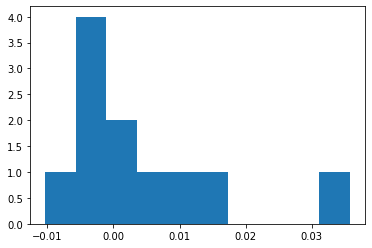

In [20]:
plt.hist(np.array(der_ests))

### Multiple

In [93]:
for col in df_orig.columns:
    if types_dict[col]=="multilevel":
        multilevel_colname = col
        print(multilevel_colname)
        break

# Find the indices corresponding to multilevel feature (job) in X_df
indices_of_col = np.nonzero(X_df.columns.str.startswith(multilevel_colname))[0]
factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_j = len(indices_of_col)
gradient_categorical = []
for i in range(n_levels_j):
    if i != level:
        xloc_chg = np.copy(xloc)
        # xloc_chg[0][indices_of_col[i]] += 0.001
        chgd_factor = np.zeros(n_levels_j)
        chgd_factor[i] = 1
        xloc_chg[0][indices_of_col] = chgd_factor
        gradient_categorical.append((model.predict_proba(xloc_chg)[0,1] - model.predict_proba(xloc)[0,1]))
    else:
        gradient_categorical.append(0)
gradient_categorical

Job


[0.011863807005246162,
 -0.010271552120080657,
 -0.003615571649206964,
 -0.002138551833722621,
 0,
 0.03573835096274598,
 -0.0008832796780694832,
 -0.005323456082368561,
 0.015954360293033723,
 -0.004140807956118785,
 0.0017164024498111247,
 0.0037791129405875673]

In [92]:
print(np.round(gradient[indices_of_col].T, 3))
print(np.round(gradient_categorical, 3))
np.corrcoef(np.array(gradient_categorical), gradient[indices_of_col].reshape(-1))[0,1] # Very highly correlated! 

[[ 0.01  -0.032 -0.017 -0.014 -0.01   0.042 -0.012 -0.021  0.016 -0.018
  -0.007 -0.003]]
[ 0.012 -0.01  -0.004 -0.002  0.     0.036 -0.001 -0.005  0.016 -0.004
  0.002  0.004]


0.9934238789821731

# Hessian Off-Diagonals $\frac{\partial^2 f}{\partial x_j \partial x_k}$
## Same Type
### Both ordinal

In [21]:
# Identify j, k = index of ordinal columns in X_train/X_test/xloc 
ord1 = None
for col in df_orig.columns:
    if types_dict[col]=="ordinal":
        if ord1 is None:
            ord1 = col
        else:
            ord2 = col
            break

# Find index of these columns in X_train
X_df = df.copy()
X_df.drop(['Success'], axis=1, inplace=True)
j = np.nonzero(X_df.columns==ord1)[0].item()
k = np.nonzero(X_df.columns==ord2)[0].item()
print(j, ord1)
print(k, ord2)

0 Age
2 Balance


In [22]:
Ks = [10000, 1000, 100, 10]
n_equal_j = np.sum(X_train[:,j] == xloc[0,j])
n_equal_k = np.sum(X_train[:,k] == xloc[0,k])
idx_dists_ordered_j = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
idx_dists_ordered_k = np.argsort(np.abs(X_train[:,k] - xloc[0,k]))

for K in Ks:
    # Find indices of K rows of X whose j'th column is closest - but not zero - to xloc's.
    idx_j = idx_dists_ordered_j[n_equal_j:(n_equal_j+K)]
    idx_k = idx_dists_ordered_k[n_equal_k:(n_equal_k+K)]
    xj_vals = X_train[idx_j, j]
    xk_vals = X_train[idx_k, k]
    values_j, counts_j = np.unique(xj_vals, return_counts=True)
    values_k, counts_k = np.unique(xk_vals, return_counts=True)
    n_unique_j = values_j.shape[0]
    n_unique_k = values_k.shape[0]
    der_ests = []
    weights = []
    for a in range(n_unique_j):
        jval, nj = values_j[a], counts_j[a]
        hj = jval - xloc[0][j]
        xloc_plus_hj = np.copy(xloc)
        xloc_plus_hj[0][j] += hj
        
        for b in range(n_unique_k):
            kval, nk = values_k[b], counts_k[b]
            hk = kval - xloc[0][k]
            xloc_plus_hk = np.copy(xloc)
            xloc_plus_hk[0][k] += hk
            xloc_plus_hj_hk = np.copy(xloc_plus_hj)
            xloc_plus_hj_hk[0][k] += hk
            der_ests.append((model.predict_proba(xloc_plus_hj_hk)[0,1]-
                            model.predict_proba(xloc_plus_hj)[0,1]-
                            model.predict_proba(xloc_plus_hk)[0,1]+
                            model.predict_proba(xloc)[0,1])/(hj*hk))
            weights.append((nj*nk)/(K**2))
    H_jk = np.sum(der_ests * np.array(weights)) # Weighted sum
    print(K, H_jk)
print(H[j,k])

10000 -1.4149445046454077e-09
1000 -1.415047714144431e-09
100 -1.4151280870710232e-09
10 -1.415235954815852e-09
-2.4069259986119463e-09


### Both Binary

In [23]:
# Identify j, k = index of ordinal columns in X_train/X_test/xloc 
bin1 = None
for col in df_orig.columns:
    if types_dict[col]=="binary":
        if bin1 is None:
            bin1 = col
        else:
            bin2 = col
            break

# Find index of these columns in X_train
X_df = df.copy()
X_df.drop(['Success'], axis=1, inplace=True)
j = np.nonzero(X_df.columns==bin1)[0].item()
k = np.nonzero(X_df.columns==bin2)[0].item()
print(j, bin1)
print(k, bin2)

1 Default
3 Housing


In [24]:
hj = 1 if xloc[0][j]==0 else -1
hk = 1 if xloc[0][k]==0 else -1

xloc_plus_hj = np.copy(xloc)
xloc_plus_hj[0][j] += hj
xloc_plus_hk = np.copy(xloc)
xloc_plus_hk[0][k] += hk
xloc_plus_hj_hk = np.copy(xloc_plus_hj)
xloc_plus_hj_hk[0][k] += hk
H_jk = (model.predict_proba(xloc_plus_hj_hk)[0,1]-
                model.predict_proba(xloc_plus_hj)[0,1]-
                model.predict_proba(xloc_plus_hk)[0,1]+
                model.predict_proba(xloc)[0,1])/(hj*hk)
# Off by factor of two
print(H_jk)
print(H[j,k])

0.001715747387314094
0.003947456796958606


### Both multilevel categorical
No great way to validate

In [25]:
# Identify two multilevel categorical variables in X_train/X_test/xloc 
cat1 = None
for col in df_orig.columns:
    if types_dict[col]=="multilevel":
        if cat1 is None:
            cat1 = col
        else:
            cat2 = col
            print(cat1, cat2)
            break

# Find the indices corresponding to them in X_df
indices_of_col1 = np.nonzero(X_df.columns.str.startswith(cat1))[0]
factor1 = xloc[0][indices_of_col1]
level1 = np.argwhere(factor1==1).item()
n_levels_j = len(indices_of_col1)

indices_of_col2 = np.nonzero(X_df.columns.str.startswith(cat2))[0]
factor2 = xloc[0][indices_of_col2]
level2 = np.argwhere(factor2==1).item()
n_levels_k = len(indices_of_col2)

der_ests = []
for a in range(n_levels_j):
    if a != level1:
        xloc_chg_j = np.copy(xloc)
        chgd_factor_j = np.zeros(n_levels_j)
        chgd_factor_j[a] = 1
        xloc_chg_j[0][indices_of_col1] = chgd_factor_j

        for b in range(n_levels_k):
            if b != level2:
                xloc_chg_k = np.copy(xloc)
                chgd_factor_k = np.zeros(n_levels_k)
                chgd_factor_k[b] = 1
                xloc_chg_k[0][indices_of_col2] = chgd_factor_k

                xloc_chg_jk = np.copy(xloc_chg_j)
                xloc_chg_jk[0][indices_of_col2] = chgd_factor_k
        
                der_ests.append(model.predict_proba(xloc_chg_jk)[0,1]-
                    model.predict_proba(xloc_chg_j)[0,1]-
                    model.predict_proba(xloc_chg_k)[0,1]+
                    model.predict_proba(xloc)[0,1]) # Giles: always count change as 1
H_jk = np.mean(der_ests)
print(H_jk)


Job Marital
0.0011670120874954352


In [26]:
j = indices_of_col1[level1]
k = indices_of_col2[level2]
print(H[j,k])

0.003686542456068404


### $H_{jk}$, both multilevel, new way

In [376]:
# Identify two multilevel categorical variables in X_train/X_test/xloc 
cat1 = None
for col in df_orig.columns:
    if types_dict[col]=="multilevel":
        if cat1 is None:
            cat1 = col
        else:
            cat2 = col
            print(cat1, cat2)
            break

# Find the indices corresponding to them in X_df
indices_of_col1 = np.nonzero(X_df.columns.str.startswith(cat1))[0]
factor1 = xloc[0][indices_of_col1]
level1 = np.argwhere(factor1==1).item()
n_levels_1 = len(indices_of_col1)

indices_of_col2 = np.nonzero(X_df.columns.str.startswith(cat2))[0]
factor2 = xloc[0][indices_of_col2]
level2 = np.argwhere(factor2==1).item()
n_levels_2 = len(indices_of_col2)

H_multi_multi = np.zeros((n_levels_1, n_levels_2))
for i in range(n_levels_1):
    if i==level1:
        H_multi_multi[i,:] = 0
        continue
    xloc_chg_1 = np.copy(xloc)
    chgd_factor_1 = np.zeros(n_levels_1)
    chgd_factor_1[i] = 1
    xloc_chg_1[0][indices_of_col1] = chgd_factor_1
    for j in range(n_levels_2):
        if j==level2:
            H_multi_multi[i,j] = 0
            continue
        xloc_chg_2 = np.copy(xloc)
        chgd_factor_2 = np.zeros(n_levels_2)
        chgd_factor_2[j] = 1
        xloc_chg_2[0][indices_of_col2] = chgd_factor_2

        xloc_chg_12 = np.copy(xloc_chg_2)
        xloc_chg_12[0][indices_of_col2] = chgd_factor_2

        H_multi_multi[i,j] = (model.predict_proba(xloc_chg_12)[0,1]-
            model.predict_proba(xloc_chg_1)[0,1]-
            model.predict_proba(xloc_chg_2)[0,1]+
            model.predict_proba(xloc)[0,1]) # Giles: always count changes as 1

                


Job Marital


In [381]:
h1 = H_multi_multi
h2 = H[:, indices_of_col2][indices_of_col1,:]
# print(H_multi_multi.T)
# print(H[:, indices_of_col2][indices_of_col1,:].T)
print(np.corrcoef(h1.reshape(-1),h2.reshape(-1))[0,1])# Not super correlated...
print(np.corrcoef(h1[:,0], h2[:,0])[0,1])# Very correlated
print(np.corrcoef(h1[:,2], h2[:,2])[0,1]) # Same. I think this is because marital has 3 levels
print(np.mean(h1/h2, axis=0)) # Close ish


0.4083634245365797
0.9934238789821732
0.9934238789821732
[1.21323877 0.         4.88675536]


In [386]:
h1

array([[-0.01186381,  0.        , -0.01186381],
       [ 0.01027155,  0.        ,  0.01027155],
       [ 0.00361557,  0.        ,  0.00361557],
       [ 0.00213855,  0.        ,  0.00213855],
       [ 0.        ,  0.        ,  0.        ],
       [-0.03573835,  0.        , -0.03573835],
       [ 0.00088328,  0.        ,  0.00088328],
       [ 0.00532346,  0.        ,  0.00532346],
       [-0.01595436,  0.        , -0.01595436],
       [ 0.00414081,  0.        ,  0.00414081],
       [-0.0017164 ,  0.        , -0.0017164 ],
       [-0.00377911,  0.        , -0.00377911]])

In [387]:
est_hessian[10:21, 22:25]

array([[ 0.00258725,  0.        ,  0.0049151 ],
       [-0.00230898,  0.        , -0.00441021],
       [-0.00080543,  0.        , -0.00153588],
       [-0.00047544,  0.        , -0.00090629],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.00753789,  0.        ,  0.01423797],
       [-0.00019603,  0.        , -0.00037357],
       [-0.00118865,  0.        , -0.00226761],
       [ 0.00345964,  0.        ,  0.00656592],
       [-0.0009231 ,  0.        , -0.00176049],
       [ 0.00037958,  0.        ,  0.00072288]])

## Different Type
### One Ordinal, One Binary

In [27]:
ordinal_col, binary_col = None, None
for col in df_orig.columns:
    if types_dict[col]=="ordinal" and ordinal_col is None:
        ordinal_col = col
    if types_dict[col]=="binary" and binary_col is None:
        binary_col = col
    if ordinal_col is not None and binary_col is not None:
        break
    
# Find index of these columns
j = np.nonzero(X_df.columns==ordinal_col)[0].item()
k = np.nonzero(X_df.columns==binary_col)[0].item()
print(j, ordinal_col)
print(k, binary_col)


0 Age
1 Default


In [28]:
hk = 1 if xloc[0][k]==0 else -1
xloc_chg_k = np.copy(xloc)
xloc_chg_k[0][k] += hk
K = 1000
n_equal = np.sum(X_train[:,j] == xloc[0,j])
idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
idx = idx_dists_ordered[n_equal:(n_equal+K)]
xj_vals = X_train[idx, j]
values_j, counts_j = np.unique(xj_vals, return_counts=True)
der_ests = []
for i in range(len(values_j)):
    hj = values_j[i] - xloc[0][j]
    xloc_plus_hj = np.copy(xloc)
    xloc_plus_hj[0][j] += hj
    xloc_chg_jk = np.copy(xloc_chg_k)
    xloc_chg_jk[0][j] += hj
    der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                    model.predict_proba(xloc_plus_hj)[0,1]-
                    model.predict_proba(xloc_chg_k)[0,1]+
                    model.predict_proba(xloc)[0,1])/(hj*hk))
H_jk = np.sum(der_ests * counts_j/K) # Weighted sum

# Off by a factor of <2
print(H_jk)
print(H[j,k])

8.071384572259921e-06
1.4200479870196244e-05


### One Ordinal, One Multilevel

In [168]:
ordinal_col, multi_col = None, None
for col in df_orig.columns:
    if types_dict[col]=="ordinal" and ordinal_col is None:
        ordinal_col = col
    if types_dict[col]=="multilevel" and multi_col is None:
        multi_col = col
    if ordinal_col is not None and multi_col is not None:
        print(ordinal_col, multi_col)
        break

# Index of ordinal feature
j = np.nonzero(X_df.columns==ordinal_col)[0].item()
# Indices of multilevel feature (job)
indices_of_col = np.nonzero(X_df.columns.str.startswith(multi_col))[0]



Age Job


In [169]:
factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_k = len(indices_of_col)
hk = 1 # Always, according to Giles

Ks = [10000, 1000, 100, 10]
for K in Ks:
    n_equal = np.sum(X_train[:,j] == xloc[0,j])
    idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
    idx = idx_dists_ordered[n_equal:(n_equal+K)]
    xj_vals = X_train[idx, j]
    values_j, counts_j = np.unique(xj_vals, return_counts=True)
    der_ests = []
    for a in range(n_levels_k): # Change feature k st different feature on
        if a != level:
            xloc_chg_k = np.copy(xloc)
            chgd_factor = np.zeros(n_levels_k)
            chgd_factor[a] = 1
            xloc_chg_k[0][indices_of_col] = chgd_factor
            for b in range(len(values_j)): # Change feature j (ordinal)
                hj = values_j[b] - xloc[0][j]
                xloc_plus_hj = np.copy(xloc)
                xloc_plus_hj[0][j] += hj
                xloc_chg_jk = np.copy(xloc_chg_k)
                xloc_chg_jk[0][j] += hj
                der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                                model.predict_proba(xloc_plus_hj)[0,1]-
                                model.predict_proba(xloc_chg_k)[0,1]+
                                model.predict_proba(xloc)[0,1])/(hj*hk))
    weights = np.tile(counts_j, n_levels_k-1) / (K*(n_levels_k-1))
    H_jk = np.sum(der_ests * weights)
    print(K, H_jk)

10000 -8.00730105754372e-06
1000 -8.00490823668195e-06
100 -8.005302658967228e-06
10 -8.005846689705539e-06


-8.005846689705539e-06
1.9363665482984658e-05


(array([2., 0., 0., 0., 2., 2., 2., 4., 8., 2.]),
 array([-7.44661119e-05, -6.47655650e-05, -5.50650181e-05, -4.53644711e-05,
        -3.56639242e-05, -2.59633773e-05, -1.62628303e-05, -6.56228340e-06,
         3.13826354e-06,  1.28388105e-05,  2.25393574e-05]),
 <BarContainer object of 10 artists>)

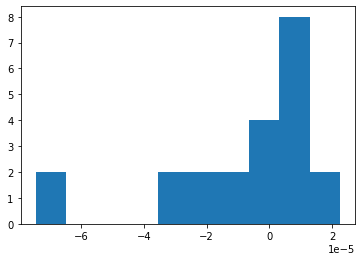

In [170]:
k = 14 # Index of level of that categorical feature
print(H_jk)
print(H[j,k])
plt.hist(der_ests)

#### New way

In [183]:
factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_k = len(indices_of_col)
hk = 1 # Always, according to Giles

K = 1000
H_ordinal_multi = np.zeros(n_levels_k)

n_equal = np.sum(X_train[:,j] == xloc[0,j])
idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
idx = idx_dists_ordered[n_equal:(n_equal+K)]
xj_vals = X_train[idx, j]
values_j, counts_j = np.unique(xj_vals, return_counts=True)

for a in range(n_levels_k): # Change feature k st different feature on
    if a == level:
        H_ordinal_multi[a] = 0
    if a != level:
        der_ests = []
        xloc_chg_k = np.copy(xloc)
        chgd_factor = np.zeros(n_levels_k)
        chgd_factor[a] = 1
        xloc_chg_k[0][indices_of_col] = chgd_factor
        for b in range(len(values_j)): # Change feature j (ordinal)
            hj = values_j[b] - xloc[0][j]
            xloc_plus_hj = np.copy(xloc)
            xloc_plus_hj[0][j] += hj
            xloc_chg_jk = np.copy(xloc_chg_k)
            xloc_chg_jk[0][j] += hj
            der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                            model.predict_proba(xloc_plus_hj)[0,1]-
                            model.predict_proba(xloc_chg_k)[0,1]+
                            model.predict_proba(xloc)[0,1])/(hj*hk))
        weights = counts_j/K
        H_ordinal_multi[a] = np.sum(der_ests * weights)


0.9951039544506997
0.2498384291404371


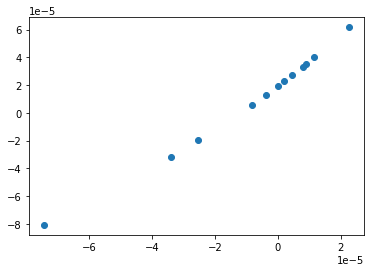

In [184]:
h1 = H_ordinal_multi
h2 = H[j, indices_of_col]
# print(h1)
# print(h2)
print(np.corrcoef(h1.reshape(-1),h2.reshape(-1))[0,1])# Highly correlated
print(np.mean(h1/h2)) # Close ish
plt.scatter(h1.reshape(-1),h2.reshape(-1))

### One binary, one multilevel

In [189]:
binary_col, multi_col = None, None
for col in df_orig.columns:
    if types_dict[col]=="binary" and binary_col is None:
        binary_col = col
    if types_dict[col]=="multilevel" and multi_col is None:
        multi_col = col
    if binary_col is not None and multi_col is not None:
        print(binary_col, multi_col)
        break

# Index of ordinal feature
j = np.nonzero(X_df.columns==binary_col)[0].item()
# Indices of multilevel feature (job)
indices_of_col = np.nonzero(X_df.columns.str.startswith(multi_col))[0]



Default Job


-0.0002723530380038461
0.0006788893266817754


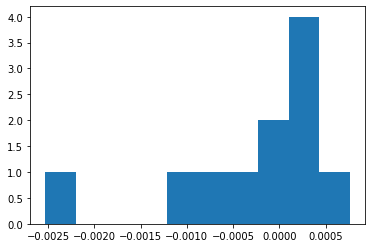

In [186]:
hj = 1 if xloc[0][j]==0 else -1

factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_k = len(indices_of_col)
hk = 1 # Always, according to Giles

der_ests = []
for a in range(n_levels_k): # Change feature k (multilevel) st different feature on
    if a != level:
        xloc_chg_k = np.copy(xloc)
        chgd_factor = np.zeros(n_levels_k)
        chgd_factor[a] = 1
        xloc_chg_k[0][indices_of_col] = chgd_factor
    
        xloc_chg_j = np.copy(xloc)
        xloc_chg_j[0][j] += hj
        xloc_chg_jk = np.copy(xloc_chg_k)
        xloc_chg_jk[0][j] += hj
        der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                        model.predict_proba(xloc_chg_j)[0,1]-
                        model.predict_proba(xloc_chg_k)[0,1]+
                        model.predict_proba(xloc)[0,1])/(hj*hk))
H_jk = np.mean(der_ests)
print(H_jk)
print(H[j,indices_of_col[level]])
plt.hist(der_ests)
plt.show()

#### New Way

In [190]:
hj = 1 if xloc[0][j]==0 else -1

factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels_k = len(indices_of_col)
hk = 1 # Always, according to Giles

H_binary_multi = np.zeros(n_levels_k)
for a in range(n_levels_k): # Change feature k (multilevel) st different feature on
    if a==level:
        H_binary_multi[a] = 0
    else:
        xloc_chg_k = np.copy(xloc)
        chgd_factor = np.zeros(n_levels_k)
        chgd_factor[a] = 1
        xloc_chg_k[0][indices_of_col] = chgd_factor
    
        xloc_chg_j = np.copy(xloc)
        xloc_chg_j[0][j] += hj
        xloc_chg_jk = np.copy(xloc_chg_k)
        xloc_chg_jk[0][j] += hj
        H_binary_multi[a] = (model.predict_proba(xloc_chg_jk)[0,1]-
                        model.predict_proba(xloc_chg_j)[0,1]-
                        model.predict_proba(xloc_chg_k)[0,1]+
                        model.predict_proba(xloc)[0,1])/(hj*hk)


0.9949839259612031
0.2418866836146455


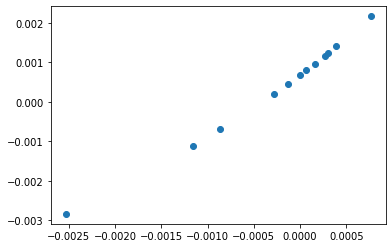

In [191]:
h1 = H_binary_multi
h2 = H[j, indices_of_col]
# print(h1)
# print(h2)
print(np.corrcoef(h1.reshape(-1),h2.reshape(-1))[0,1])# Highly correlated
print(np.mean(h1/h2)) # Close ish
plt.scatter(h1.reshape(-1),h2.reshape(-1))

In [201]:


# H_package


### Having looked at all possible pairs of features, it seems as though everything is off by a factor of at most two, except for perhaps the first and second derivates involving the multilevel categorical variables.

## Compute gradient vector

In [34]:
'''
for each feature:
    check if it's ordinal, binary, or multilevel (in future datasets, may be continuous; this can be handled like ordinal)
    if ordinal or binary:
        get index for feature
    else:
        get all indices for feature
    if ordinal:
        Get K nearest values of feature, and count breakdown
        For each unique value of feature:
            Estimate derivative
        Take weighted sum, weighted by counts
    if binary:
        Take difference (feature on vs off)
    if multilevel:
        For all other possible levels:
            Compute difference if that level was on
        Take average
'''


"\nfor each feature:\n    check if it's ordinal, binary, or multilevel (in future datasets, may be continuous; this can be handled like ordinal)\n    if ordinal or binary:\n        get index for feature\n    else:\n        get all indices for feature\n    if ordinal:\n        Get K nearest values of feature, and count breakdown\n        For each unique value of feature:\n            Estimate derivative\n        Take weighted sum, weighted by counts\n    if binary:\n        Take difference (feature on vs off)\n    if multilevel:\n        For all other possible levels:\n            Compute difference if that level was on\n        Take average\n"

array([[-2.09328114e-04],
       [-7.33903519e-03],
       [ 1.24393787e-06],
       [-5.81891383e-02],
       [-5.23785281e-02],
       [-1.89344025e-04],
       [ 3.50905882e-04],
       [-8.21114795e-03],
       [-1.12225428e-04],
       [-2.40644790e-04],
       [ 1.03222835e-02],
       [-3.19016774e-02],
       [-1.71559618e-02],
       [-1.41712004e-02],
       [-1.00074521e-02],
       [ 4.18118869e-02],
       [-1.17054393e-02],
       [-2.07273456e-02],
       [ 1.64609021e-02],
       [-1.82401614e-02],
       [-6.79085279e-03],
       [-3.06132587e-03],
       [-2.02788593e-02],
       [-3.98528358e-02],
       [-5.03464906e-03],
       [-3.75065271e-02],
       [-2.19094218e-02],
       [ 2.05846163e-04],
       [-5.95624135e-03],
       [ 1.95350534e-02],
       [ 9.20058332e-03],
       [-9.39019809e-02],
       [ 1.79722776e-02],
       [-5.33972431e-02],
       [ 1.20842872e-02],
       [-1.28987592e-02],
       [-3.47378824e-02],
       [-5.97410701e-02],
       [ 2.4

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [219]:
binarized_feature_names = np.array(X_df.columns)
binarized_feature_names

array(['Age', 'Default', 'Balance', 'Housing', 'Loan', 'Day', 'Duration',
       'Campaign', 'Prev_Days', 'Prev_Contacts', 'Job_admin.',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed',
       'Job_services', 'Job_student', 'Job_technician', 'Job_unemployed',
       'Job_unknown', 'Marital_divorced', 'Marital_married',
       'Marital_single', 'Education_primary', 'Education_secondary',
       'Education_tertiary', 'Education_unknown', 'Contact_cellular',
       'Contact_telephone', 'Contact_unknown', 'Month_apr', 'Month_aug',
       'Month_dec', 'Month_feb', 'Month_jan', 'Month_jul', 'Month_jun',
       'Month_mar', 'Month_may', 'Month_nov', 'Month_oct', 'Month_sep',
       'Prev_Outcome_failure', 'Prev_Outcome_other',
       'Prev_Outcome_success', 'Prev_Outcome_unknown'], dtype=object)

In [241]:
j = 10
multilevel_feats = []
for key, value in types_dict.items():
    if value=="multilevel":
        multilevel_feats.append(key)

for feature in multilevel_feats:
    if binarized_feature_names[j].startswith(feature):
        break

indices_of_col = np.nonzero(X_df.columns.str.startswith(feature))[0]
factor = xloc[0][indices_of_col]
level = np.argwhere(factor==1).item()
n_levels = len(indices_of_col)
if j==indices_of_col[level]:
    derivative = 0
else:
    xloc_chg = np.copy(xloc)
    xloc_chg[0][j] = 1
    xloc_chg[0][indices_of_col[level]] = 0
    # chgd_factor = np.zeros(n_levels)
    # chgd_factor[] = 1
    # xloc_chg[0][indices_of_col] = chgd_factor
    derivative = model.predict_proba(xloc_chg)[0,1] - model.predict_proba(xloc)[0,1]

    # xloc_chg = np.copy(xloc)
    # chgd_factor = np.zeros(n_levels)
    # chgd_factor[i] = 1
    # xloc_chg[0][indices_of_col] = chgd_factor
    # derivative = model.predict_proba(xloc_chg)[0,1] - model.predict_proba(xloc)[0,1]
derivative
    

0.011863807005246162

In [238]:
gradient[j]

array([0.01032228])

In [249]:
verbose=False
est_gradient = []
for j in range(d_binarized):
    if np.isin(binarized_feature_names[j], feature_names):
        # Not a multilevel feature
        colname = binarized_feature_names[j]
        type = types_dict[colname]
        if type=="ordinal":
            K = 1000
            n_equal = np.sum(X_train[:,j] == xloc[0,j])
            idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))

            # Find indices of K rows of X whose j'th column is closest - but not zero - to xloc's.
            idx = idx_dists_ordered[n_equal:(n_equal+K)]
            xj_vals = X_train[idx, j]
            values, counts = np.unique(xj_vals, return_counts=True)
            der_ests = [0]*len(values)
            for i in range(len(values)):
                h = values[i] - xloc[0][j]
                xloc_plus_h = np.copy(xloc)
                xloc_plus_h[0][j] += h
                der_ests[i] = (model.predict_proba(xloc_plus_h)[0,1] - model.predict_proba(xloc)[0,1])/h
            derivative = np.sum(der_ests * counts/sum(counts)) # Weighted sum
        elif type=="binary":
            xloc_feature_on, xloc_feature_off = np.copy(xloc), np.copy(xloc)
            xloc_feature_off[0][j] = 0
            xloc_feature_on[0][j] = 1
            derivative = model.predict_proba(xloc_feature_on)[0,1] - model.predict_proba(xloc_feature_off)[0,1]
    else:# multilevel
        for feature in multilevel_feats:
            if binarized_feature_names[j].startswith(feature):
                break

        indices_of_col = np.nonzero(X_df.columns.str.startswith(feature))[0]
        factor = xloc[0][indices_of_col]
        level = np.argwhere(factor==1).item()
        n_levels = len(indices_of_col)
        if j==indices_of_col[level]:
            derivative = 0
        else:
            xloc_chg = np.copy(xloc)
            xloc_chg[0][j] = 1
            xloc_chg[0][indices_of_col[level]] = 0
            derivative = model.predict_proba(xloc_chg)[0,1] - model.predict_proba(xloc)[0,1]

    est_gradient.append(derivative)
    if verbose:
        print("{}, {}".format(colname, type))
        print(derivative)
        # Reality check this against true derivative.
        print(gradient[j].item())    

est_gradient = np.array(est_gradient)

In [260]:
# The estimated gradients for ordinal and binary features are all almost exactly half of the true values
print('ordinal gradient ratios:')
j_idx = []
for j in range(d_binarized):
    colname = binarized_feature_names[j]
    if np.isin(colname, feature_names):
        type = types_dict[colname]
        if type=="ordinal":
            j_idx.append(j)
print(np.corrcoef(est_gradient[j_idx], gradient[j_idx].reshape(-1))[0,1])

print('binary gradient ratios:')
j_idx = []
for j in range(d_binarized):
    colname = binarized_feature_names[j]
    if np.isin(colname, feature_names):
        type = types_dict[colname]
        if type=="binary":
            j_idx.append(j)
print(np.corrcoef(est_gradient[j_idx], gradient[j_idx].reshape(-1))[0,1])

j_idx = []
print('multilevel gradient ratios:')
for j in range(d_binarized):
    colname = binarized_feature_names[j]
    if not np.isin(colname, feature_names):
        # Multilevel
        j_idx.append(j)
print(np.corrcoef(est_gradient[j_idx], gradient[j_idx].reshape(-1))[0,1])

ordinal gradient ratios:
0.9999987607453285
binary gradient ratios:
0.99970201901294
multilevel gradient ratios:
0.7354708769747983


## OK so the big gradient takeaways:
- Calculated this way, the estimated gradients of ordinal and binary features are around half of what they really are
- Extremely high correlation between gradients of ordinal & binary features
- Old way, multilevel: Our estimated derivates always have the flipped sign. Their magnitude is less consistent.
- New way, multilevel: Decent correlation, 0.75.

## Compute Hessian Matrix (new way)

In [266]:
def ordinal_second_deriv(colname, K=1000):
    # Index in training dataset, which binarizes columns that are originally categorical with multiple levels
    j = np.nonzero(X_df.columns==colname)[0].item() 
    n_equal = np.sum(X_train[:,j] == xloc[0,j])
    idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))

    # Find indices of K rows of X whose j'th features are closest - but not equal - to xloc's.
    idx = idx_dists_ordered[n_equal:(n_equal+K)]
    xj_vals = X_train[idx, j]
    values, counts = np.unique(xj_vals, return_counts=True)
    np.unique(xj_vals, return_counts=True)
    second_der_ests = [0]*len(values)
    for i in range(len(values)):
        h = values[i] - xloc[0][j]
        xloc_plus_h = np.copy(xloc)
        xloc_plus_h[0][j] += h
        xloc_minus_h = np.copy(xloc)
        xloc_minus_h[0][j] -= h
        second_der_ests[i] = (model.predict_proba(xloc_plus_h)[0,1] 
                        - 2*model.predict_proba(xloc)[0,1] 
                        + model.predict_proba(xloc_minus_h)[0,1])/(h**2)
    second_derivative = np.sum(second_der_ests * counts/sum(counts)) # Weighted sum
    return second_derivative



def Hjk_ordinal_ordinal(colname_j, colname_k, K=1000):
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    n_equal_j = np.sum(X_train[:,j] == xloc[0,j])
    n_equal_k = np.sum(X_train[:,k] == xloc[0,k])
    idx_dists_ordered_j = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
    idx_dists_ordered_k = np.argsort(np.abs(X_train[:,k] - xloc[0,k]))

    # Find indices of K rows of X whose j'th column is closest - but not zero - to xloc's.
    idx_j = idx_dists_ordered_j[n_equal_j:(n_equal_j+K)]
    idx_k = idx_dists_ordered_k[n_equal_k:(n_equal_k+K)]
    xj_vals = X_train[idx_j, j]
    xk_vals = X_train[idx_k, k]
    values_j, counts_j = np.unique(xj_vals, return_counts=True)
    values_k, counts_k = np.unique(xk_vals, return_counts=True)
    n_unique_j = values_j.shape[0]
    n_unique_k = values_k.shape[0]
    der_ests = []
    weights = []
    for a in range(n_unique_j):
        jval, nj = values_j[a], counts_j[a]
        hj = jval - xloc[0][j]
        xloc_plus_hj = np.copy(xloc)
        xloc_plus_hj[0][j] += hj
        
        for b in range(n_unique_k):
            kval, nk = values_k[b], counts_k[b]
            hk = kval - xloc[0][k]
            xloc_plus_hk = np.copy(xloc)
            xloc_plus_hk[0][k] += hk
            xloc_plus_hj_hk = np.copy(xloc_plus_hj)
            xloc_plus_hj_hk[0][k] += hk
            der_ests.append((model.predict_proba(xloc_plus_hj_hk)[0,1]-
                            model.predict_proba(xloc_plus_hj)[0,1]-
                            model.predict_proba(xloc_plus_hk)[0,1]+
                            model.predict_proba(xloc)[0,1])/(hj*hk))
            weights.append((nj*nk)/(K**2))
    H_jk = np.sum(der_ests * np.array(weights)) # Weighted sum
    return H_jk
    

def Hjk_binary_binary(colname_j, colname_k):
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    hj = 1 if xloc[0][j]==0 else -1
    hk = 1 if xloc[0][k]==0 else -1

    xloc_plus_hj = np.copy(xloc)
    xloc_plus_hj[0][j] += hj
    xloc_plus_hk = np.copy(xloc)
    xloc_plus_hk[0][k] += hk
    xloc_plus_hj_hk = np.copy(xloc_plus_hj)
    xloc_plus_hj_hk[0][k] += hk
    H_jk = (model.predict_proba(xloc_plus_hj_hk)[0,1]-
                    model.predict_proba(xloc_plus_hj)[0,1]-
                    model.predict_proba(xloc_plus_hk)[0,1]+
                    model.predict_proba(xloc)[0,1])/(hj*hk)
    return H_jk


def Hjk_ordinal_binary(colname_j, colname_k, K=1000, verbose=False):
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    hk = 1 if xloc[0][k]==0 else -1
    xloc_chg_k = np.copy(xloc)
    xloc_chg_k[0][k] += hk
    K = 1000
    n_equal = np.sum(X_train[:,j] == xloc[0,j])
    idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
    idx = idx_dists_ordered[n_equal:(n_equal+K)]
    xj_vals = X_train[idx, j]
    values_j, counts_j = np.unique(xj_vals, return_counts=True)
    der_ests = []
    for i in range(len(values_j)):
        hj = values_j[i] - xloc[0][j]
        xloc_plus_hj = np.copy(xloc)
        xloc_plus_hj[0][j] += hj
        xloc_chg_jk = np.copy(xloc_chg_k)
        xloc_chg_jk[0][j] += hj
        der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                        model.predict_proba(xloc_plus_hj)[0,1]-
                        model.predict_proba(xloc_chg_k)[0,1]+
                        model.predict_proba(xloc)[0,1])/(hj*hk))
    H_jk = np.sum(der_ests * counts_j/K) # Weighted sum
    return H_jk



In [448]:
def Hjk_multi_multi(colname_j, colname_k, flip_sign=False):
    # Find the indices corresponding to these columns in X_df
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    multilevel_feats = get_multilevel_features()
    for feature_j in multilevel_feats:
        if colname_j.startswith(feature_j):
            break
    indices_of_col1 = np.nonzero(X_df.columns.str.startswith(feature_j))[0]
    factor1 = xloc[0][indices_of_col1]
    level1 = np.argwhere(factor1==1).item()
    

    for feature_k in multilevel_feats:
        if colname_k.startswith(feature_k):
            break
    indices_of_col2 = np.nonzero(X_df.columns.str.startswith(feature_k))[0]
    factor2 = xloc[0][indices_of_col2]
    level2 = np.argwhere(factor2==1).item()

    if np.array_equal(indices_of_col1, indices_of_col2):
        # Same feature - 2 levels can't be on
        H_jk = 0
    elif j==indices_of_col1[level1] or k==indices_of_col2[level2]:
        # Either feature in question is already on
        H_jk = 0
    else:
        # Both different
        xloc_chg_1 = np.copy(xloc)
        xloc_chg_1[0][j] = 1
        xloc_chg_1[0][indices_of_col1[level1]] = 0

        xloc_chg_2 = np.copy(xloc)
        xloc_chg_2[0][k] = 1
        xloc_chg_2[0][indices_of_col2[level2]] = 0

        xloc_chg_12 = np.copy(xloc_chg_2)
        xloc_chg_12[0][j] = 1
        xloc_chg_12[0][indices_of_col1[level1]] = 0

        H_jk = (model.predict_proba(xloc_chg_12)[0,1]-
            model.predict_proba(xloc_chg_1)[0,1]-
            model.predict_proba(xloc_chg_2)[0,1]+
            model.predict_proba(xloc)[0,1]) # Giles: always count changes as 1
        if flip_sign:
            H_jk *= -1
    return H_jk
    

def Hjk_ordinal_multilevel(colname_j, colname_k, K = 1000):
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    multilevel_feats = get_multilevel_features()
    for feature_k in multilevel_feats:
        if colname_k.startswith(feature_k):
            break
    indices_of_col_k = np.nonzero(X_df.columns.str.startswith(feature_k))[0]
    factor = xloc[0][indices_of_col_k]
    level = np.argwhere(factor==1).item()
    if k==indices_of_col_k[level]:
        H_jk = 0
    else:
        hk = 1
        # Get adjacent values of ordinal feature (j) and their relative frequencies
        n_equal = np.sum(X_train[:,j] == xloc[0,j])
        idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
        idx = idx_dists_ordered[n_equal:(n_equal+K)]
        xj_vals = X_train[idx, j]
        values_j, counts_j = np.unique(xj_vals, return_counts=True)
        weights = counts_j/K

        # Change feature k (column of multilevel feature)
        xloc_chg_k = np.copy(xloc)
        xloc_chg_k[0,k] = 1
        xloc_chg_k[0,indices_of_col_k[level]] = 0
        der_ests = []
        for b in range(len(values_j)): # Change feature j (ordinal)
            hj = values_j[b] - xloc[0][j]
            xloc_plus_hj = np.copy(xloc)
            xloc_plus_hj[0][j] += hj
            xloc_chg_jk = np.copy(xloc_chg_k)
            xloc_chg_jk[0][j] += hj
            der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
                            model.predict_proba(xloc_plus_hj)[0,1]-
                            model.predict_proba(xloc_chg_k)[0,1]+
                            model.predict_proba(xloc)[0,1])/(hj*hk))
        
        H_jk = np.sum(der_ests * weights)
    return H_jk

def Hjk_binary_multilevel(colname_j, colname_k):
    j = np.nonzero(X_df.columns==colname_j)[0].item()
    k = np.nonzero(X_df.columns==colname_k)[0].item()
    multilevel_feats = get_multilevel_features()
    for feature_k in multilevel_feats:
        if colname_k.startswith(feature_k):
            break
    indices_of_col_k = np.nonzero(X_df.columns.str.startswith(feature_k))[0]
    factor = xloc[0][indices_of_col_k]
    level = np.argwhere(factor==1).item()
    if k==indices_of_col_k[level]:
        H_jk = 0
    else:
        # Change feature k (column of multilevel feature)
        xloc_chg_k = np.copy(xloc)
        xloc_chg_k[0,k] = 1
        xloc_chg_k[0,indices_of_col_k[level]] = 0

        hj = 1 if xloc[0][j]==0 else -1
        xloc_chg_j = np.copy(xloc)
        xloc_chg_j[0,j] += hj

        xloc_chg_jk = np.copy(xloc_chg_k)
        xloc_chg_jk[0,j] += hj

        H_jk = (model.predict_proba(xloc_chg_jk)[0,1]-
                            model.predict_proba(xloc_chg_j)[0,1]-
                            model.predict_proba(xloc_chg_k)[0,1]+
                            model.predict_proba(xloc)[0,1])
    return H_jk


In [449]:
est_hessian = np.zeros((d_binarized,d_binarized))
for j in range(d_binarized):
    colname_j = binarized_feature_names[j]
    for k in range(j+1):
        if j==k:
            # Take second derivative
            if np.isin(colname_j, feature_names):
                # Feature is binary or ordinal, not multilevel
                type = types_dict[colname_j]
                if type=="ordinal":
                    est_hessian[j, j] = ordinal_second_deriv(colname_j)
            else:
                # Multilevel or ordinal
                est_hessian[j, j] = 0
        else:
            colname_k = binarized_feature_names[k]
            type_j = types_dict[colname_j] if np.isin(colname_j, feature_names) else "multilevel"
            type_k = types_dict[colname_k] if np.isin(colname_k, feature_names) else "multilevel"
            # Both same type
            if type_j=="ordinal" and type_k=="ordinal":
                H_jk = Hjk_ordinal_ordinal(colname_j, colname_k)
            elif type_j=="binary" and type_k=="binary":
                H_jk = Hjk_binary_binary(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="multilevel":
                H_jk = Hjk_multi_multi(colname_j, colname_k)
                
            # # Of different types
            # # <ordinal, binary>.
            if type_j=="ordinal" and type_k=="binary":
                H_jk = Hjk_ordinal_binary(colname_j, colname_k)
            elif type_j=="binary" and type_k=="ordinal":
                H_jk = Hjk_ordinal_binary(colname_k, colname_j)
            
            # <ordinal, multilevel>. 
            if type_j=="ordinal" and type_k=="multilevel":
                H_jk = Hjk_ordinal_multilevel(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="ordinal":
                H_jk = Hjk_ordinal_multilevel(colname_k, colname_j)

            # <binary, multilevel>. TO DO
            if type_j=="binary" and type_k=="multilevel":
                H_jk = Hjk_binary_multilevel(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="binary":
                H_jk = Hjk_binary_multilevel(colname_k, colname_j)
            
            est_hessian[j, k] = H_jk
            est_hessian[k, j] = H_jk


            

In [450]:
# Extremely high correlation for ordinal, multi and binary, multi pairings
print(np.corrcoef(est_hessian[0, 10:21].reshape(-1), H[0, 10:21].reshape(-1)))# ordinal, multi
print(np.corrcoef(est_hessian[1, 10:21].reshape(-1), H[1, 10:21].reshape(-1)))# binary, multi
print(np.corrcoef(H.reshape(-1), est_hessian.reshape(-1)))# Overall relatively low correlation…

print(np.corrcoef(est_hessian[10:21, 22:25].reshape(-1), H[10:21, 22:25].reshape(-1)))# multi, another multi. BAD, flipped
print(np.corrcoef(est_hessian[10:21, 22].reshape(-1), H[10:21, 22].reshape(-1)))# multi, another multi. Flipped. weird…
print(np.corrcoef(est_hessian[10:21, 24].reshape(-1), H[10:21, 24].reshape(-1)))# multi, another multi. Flipped. weird…


[[1.         0.99548519]
 [0.99548519 1.        ]]
[[1.         0.99537415]
 [0.99537415 1.        ]]
[[1.         0.33719426]
 [0.33719426 1.        ]]
[[ 1.         -0.32603734]
 [-0.32603734  1.        ]]
[[ 1.         -0.99581582]
 [-0.99581582  1.        ]]
[[ 1.         -0.99611058]
 [-0.99611058  1.        ]]


### Repeat but flip sign for hessian

In [451]:
est_hessian_flipped = np.zeros((d_binarized,d_binarized))
for j in range(d_binarized):
    colname_j = binarized_feature_names[j]
    for k in range(j+1):
        if j==k:
            # Take second derivative
            if np.isin(colname_j, feature_names):
                # Feature is binary or ordinal, not multilevel
                type = types_dict[colname_j]
                if type=="ordinal":
                    est_hessian_flipped[j, j] = ordinal_second_deriv(colname_j)
            else:
                # Multilevel or ordinal
                est_hessian_flipped[j, j] = 0
        else:
            colname_k = binarized_feature_names[k]
            type_j = types_dict[colname_j] if np.isin(colname_j, feature_names) else "multilevel"
            type_k = types_dict[colname_k] if np.isin(colname_k, feature_names) else "multilevel"
            # Both same type
            if type_j=="ordinal" and type_k=="ordinal":
                H_jk = Hjk_ordinal_ordinal(colname_j, colname_k)
            elif type_j=="binary" and type_k=="binary":
                H_jk = Hjk_binary_binary(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="multilevel":
                H_jk = Hjk_multi_multi(colname_j, colname_k, flip_sign=True)
                
            # # Of different types
            # # <ordinal, binary>.
            if type_j=="ordinal" and type_k=="binary":
                H_jk = Hjk_ordinal_binary(colname_j, colname_k)
            elif type_j=="binary" and type_k=="ordinal":
                H_jk = Hjk_ordinal_binary(colname_k, colname_j)
            
            # <ordinal, multilevel>. 
            if type_j=="ordinal" and type_k=="multilevel":
                H_jk = Hjk_ordinal_multilevel(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="ordinal":
                H_jk = Hjk_ordinal_multilevel(colname_k, colname_j)

            # <binary, multilevel>. TO DO
            if type_j=="binary" and type_k=="multilevel":
                H_jk = Hjk_binary_multilevel(colname_j, colname_k)
            elif type_j=="multilevel" and type_k=="binary":
                H_jk = Hjk_binary_multilevel(colname_k, colname_j)
            
            est_hessian_flipped[j, k] = H_jk
            est_hessian_flipped[k, j] = H_jk


            

In [452]:
# Extremely high correlation for ordinal, multi and binary, multi pairings
print(np.corrcoef(est_hessian_flipped[0, 10:21].reshape(-1), H[0, 10:21].reshape(-1)))# ordinal, multi
print(np.corrcoef(est_hessian_flipped[1, 10:21].reshape(-1), H[1, 10:21].reshape(-1)))# binary, multi
print(np.corrcoef(H.reshape(-1), est_hessian_flipped.reshape(-1)))# Overall relatively low correlation…

print(np.corrcoef(est_hessian_flipped[10:21, 22:25].reshape(-1), H[10:21, 22:25].reshape(-1)))# multi, another multi. BAD, flipped
print(np.corrcoef(est_hessian_flipped[10:21, 22].reshape(-1), H[10:21, 22].reshape(-1)))# multi, another multi. Flipped. weird…
print(np.corrcoef(est_hessian_flipped[10:21, 24].reshape(-1), H[10:21, 24].reshape(-1)))# multi, another multi. Flipped. weird…


[[1.         0.99548519]
 [0.99548519 1.        ]]
[[1.         0.99537415]
 [0.99537415 1.        ]]
[[ 1.         -0.17479691]
 [-0.17479691  1.        ]]
[[1.         0.32603734]
 [0.32603734 1.        ]]
[[1.         0.99581582]
 [0.99581582 1.        ]]
[[1.         0.99611058]
 [0.99611058 1.        ]]


## OK, so the big takeaways:
Second derivatives
- The second derivatives of ordinal features - both wrt the same variable and different ones - are consistently around half of the true values. Strangely, the ratio hovers almost exactly around 0.58.
- Binary variables are calculated to actually have a second derivative (permitting infinitesimal change).
- The second derivative of multilevel features are of the right sign. Their magnitude can be way off, though.

Hessian off-diagonals
- When one feature is ordinal and the other is binary, the estimated Hessian is around half of the true value.
- When one feature is categorical with >2 levels and the other isn't (either binary or ordinal), the estimated hessian has the opposite sign. (That is, if we compare this to the Hessian of the binarized data.) The magnitudes are all over the place, but might be (negative) half on average with some outliers.

In [453]:
dirpath = "/Users/jeremygoldwasser/Desktop/SHAP/Data/bank"
from os.path import join
np.save(join(dirpath, "gradient.npy"), est_gradient)
np.save(join(dirpath, "hessian.npy"), est_hessian)
np.save(join(dirpath, "hessian_flipped.npy"), est_hessian_flipped)
np.save(join(dirpath, "X_train.npy"), X_train)
np.save(join(dirpath, "X_val.npy"), X_val)
np.save(join(dirpath, "X_test.npy"), X_test)
np.save(join(dirpath, "Y_train.npy"), Y_train)
np.save(join(dirpath, "Y_val.npy"), Y_val)
np.save(join(dirpath, "Y_test.npy"), Y_test)
X_df.to_csv(join(dirpath, "X_df.csv"), index=False)
df_orig.to_csv(join(dirpath, "df_orig.csv"), index=False)


In [444]:

filename = 'logreg_model.sav'
pickle.dump(model, open(join(dirpath, filename), 'wb'))


## Compute Hessian Matrix (old way)

In [417]:
# def old_Hjk_multi_multi(colname_j, colname_k, verbose=False):
#     # Find the indices corresponding to them in X_df
#     indices_of_col_j = np.nonzero(X_df.columns.str.startswith(colname_j))[0]
#     factor_j = xloc[0][indices_of_col_j]
#     level_j = np.argwhere(factor_j==1).item()
#     n_levels_j = len(indices_of_col_j)

#     indices_of_col_k = np.nonzero(X_df.columns.str.startswith(colname_k))[0]
#     factor_k = xloc[0][indices_of_col_k]
#     level_k = np.argwhere(factor_k==1).item()
#     n_levels_k = len(indices_of_col_k)

#     der_ests = []
#     for a in range(n_levels_j):
#         if a != level_j:
#             xloc_chg_j = np.copy(xloc)
#             chgd_factor_j = np.zeros(n_levels_j)
#             chgd_factor_j[a] = 1
#             xloc_chg_j[0][indices_of_col_j] = chgd_factor_j

#             for b in range(n_levels_k):
#                 if b != level_k:
#                     xloc_chg_k = np.copy(xloc)
#                     chgd_factor_k = np.zeros(n_levels_k)
#                     chgd_factor_k[b] = 1
#                     xloc_chg_k[0][indices_of_col_k] = chgd_factor_k

#                     xloc_chg_jk = np.copy(xloc_chg_j)
#                     xloc_chg_jk[0][indices_of_col_k] = chgd_factor_k
            
#                     der_ests.append(model.predict_proba(xloc_chg_jk)[0,1]-
#                         model.predict_proba(xloc_chg_j)[0,1]-
#                         model.predict_proba(xloc_chg_k)[0,1]+
#                         model.predict_proba(xloc)[0,1]) # Giles: always count change as 1
#     H_jk = np.mean(der_ests)
#     if verbose:
#         print(colname_j, colname_k)
#         j, k = indices_of_col_j[level_j], indices_of_col_k[level_k]
#         print("True: {}".format(H[j,k]))
#         print("Est: {}".format(H_jk))
#     return H_jk

In [418]:


# def old_Hjk_ordinal_multilevel(colname_j, colname_k, K=1000, verbose=False):
#     j = np.nonzero(X_df.columns==colname_j)[0].item()
#     indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_k))[0]
#     # Get information about categorical feature
#     factor = xloc[0][indices_of_col]
#     level = np.argwhere(factor==1).item()
#     n_levels_k = len(indices_of_col)
#     hk = 1

#     # Find nearby values of ordinal feature
#     n_equal = np.sum(X_train[:,j] == xloc[0,j])
#     idx_dists_ordered = np.argsort(np.abs(X_train[:,j] - xloc[0,j]))
#     idx = idx_dists_ordered[n_equal:(n_equal+K)]
#     xj_vals = X_train[idx, j]
#     values_j, counts_j = np.unique(xj_vals, return_counts=True)
#     der_ests = []
#     for a in range(n_levels_k): # Change feature k st a different feature is on
#         if a != level:
#             xloc_chg_k = np.copy(xloc)
#             chgd_factor = np.zeros(n_levels_k)
#             chgd_factor[a] = 1
#             xloc_chg_k[0][indices_of_col] = chgd_factor
#             for b in range(len(values_j)): # Change feature j (ordinal)
#                 hj = values_j[b] - xloc[0][j]
#                 xloc_plus_hj = np.copy(xloc)
#                 xloc_plus_hj[0][j] += hj
#                 xloc_chg_jk = np.copy(xloc_chg_k)
#                 xloc_chg_jk[0][j] += hj
#                 der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
#                                 model.predict_proba(xloc_plus_hj)[0,1]-
#                                 model.predict_proba(xloc_chg_k)[0,1]+
#                                 model.predict_proba(xloc)[0,1])/(hj*hk))
#     weights = np.tile(counts_j, n_levels_k-1) / (K*(n_levels_k-1))
#     H_jk = np.sum(der_ests * weights)
#     if verbose:
#         print(colname_j, colname_k)
#         print("True: {}".format(H[j,k]))
#         print("Est: {}".format(H_jk))
#     return H_jk

    

# def old_Hjk_binary_multilevel(colname_j, colname_k, verbose=False):
#     j = np.nonzero(X_df.columns==colname_j)[0].item()
#     indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_k))[0]

#     hj = 1 if xloc[0][j]==0 else -1
#     # Get information about categorical variable
#     factor = xloc[0][indices_of_col]
#     level = np.argwhere(factor==1).item()
#     n_levels_k = len(indices_of_col)
#     hk = 1 # Always, according to Giles

#     der_ests = []
#     for a in range(n_levels_k): # Change feature k (multilevel) st different feature on
#         if a != level:
#             xloc_chg_k = np.copy(xloc)
#             chgd_factor = np.zeros(n_levels_k)
#             chgd_factor[a] = 1
#             xloc_chg_k[0][indices_of_col] = chgd_factor
        
#             xloc_chg_j = np.copy(xloc)
#             xloc_chg_j[0][j] += hj
#             xloc_chg_jk = np.copy(xloc_chg_k)
#             xloc_chg_jk[0][j] += hj
#             der_ests.append((model.predict_proba(xloc_chg_jk)[0,1]-
#                             model.predict_proba(xloc_chg_j)[0,1]-
#                             model.predict_proba(xloc_chg_k)[0,1]+
#                             model.predict_proba(xloc)[0,1])/(hj*hk))
#     H_jk = np.mean(der_ests)
#     if verbose:
#         print(colname_j, colname_k)
#         print("True: {}".format(H[j,indices_of_col[level]]))
#         print("Est: {}".format(H_jk))
#     return H_jk



In [419]:
# est_hessian = np.zeros((d_orig, d_orig))
# K = 1000
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig+1): # Symmetric
#         if j_orig==k_orig:
#             # Take second derivative
#             colname = feature_names[j_orig]
#             type = types_dict[colname]
#             if type=="binary" or type=="multilevel":
#                 est_hessian[j_orig, j_orig] = 0
#             else:# Ordinal
#                 second_derivative = ordinal_second_deriv(colname)
#                 est_hessian[j_orig, j_orig] = second_derivative
#         else:
#             colname_j = feature_names[j_orig]
#             type_j = types_dict[colname_j]
#             colname_k = feature_names[k_orig]
#             type_k = types_dict[colname_k]

#             # Both the same type
#             if type_j=="ordinal" and type_k=="ordinal":
#                 # So far so good. Close to half
#                 H_jk = Hjk_ordinal_ordinal(colname_j, colname_k)
#             elif type_j=="binary" and type_k=="binary":
#                 H_jk = Hjk_binary_binary(colname_j, colname_k) # So far so good. Definitely close to half
#             elif type_j=="multilevel" and type_k=="multilevel":
#                 H_jk = Hjk_multi_multi(colname_j, colname_k) # Not too far off...
                
#             # Of different types
#             # <ordinal, binary>. Definitely close to half
#             if type_j=="ordinal" and type_k=="binary":
#                 H_jk = Hjk_ordinal_binary(colname_j, colname_k)
#             elif type_j=="binary" and type_k=="ordinal":
#                 H_jk = Hjk_ordinal_binary(colname_k, colname_j)
            
#             # <ordinal, multilevel>. Often relatively close but sign usually flipped
#             if type_j=="ordinal" and type_k=="multilevel":
#                 H_jk = Hjk_ordinal_multilevel(colname_j, colname_k)
#             elif type_j=="multilevel" and type_k=="ordinal":
#                 H_jk = Hjk_ordinal_multilevel(colname_k, colname_j)

#             # <binary, multilevel>. less correlated but somewhat, & sign usually flipped
#             if type_j=="binary" and type_k=="multilevel":
#                 H_jk = Hjk_binary_multilevel(colname_j, colname_k)
#             elif type_j=="multilevel" and type_k=="binary":
#                 H_jk = Hjk_binary_multilevel(colname_k, colname_j)
            
#             est_hessian[j_orig, k_orig] = H_jk
#             est_hessian[k_orig, j_orig] = H_jk


            

In [421]:
# # The estimated hessians for ordinal and binary features
# print('ordinal second derivative ratios:')# Again, all almost exactly half of the true values
# for j_orig in range(d_orig):
#     colname = feature_names[j_orig]
#     type = types_dict[colname]
#     if type == "ordinal":
#         j = np.nonzero(X_df.columns==colname)[0].item()
#         print(np.round(est_hessian[j_orig, j_orig]/H[j,j].item(), 8)) # Conspicuously close to one another...

# print('True binary second derivatives:')
# for j_orig in range(d_orig):
#     colname = feature_names[j_orig]
#     type = types_dict[colname]
#     if type == "binary":
#         j = np.nonzero(X_df.columns==colname)[0].item()
#         print(H[j,j].item())

# print('True multilevel second derivatives:')
# for j_orig in range(d_orig):
#     colname = feature_names[j_orig]
#     type = types_dict[colname]
#     if type == "multilevel":
#         indices_of_col = np.nonzero(X_df.columns.str.startswith(colname))[0]
#         factor = xloc[0][indices_of_col]
#         level = np.argwhere(factor==1).item()
#         print(np.round(gradient[indices_of_col[level]].item(), 4))


In [422]:
# # Ordinal-ordinal ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="ordinal" and type_k=="ordinal":
#             j = np.nonzero(X_df.columns==colname_j)[0].item()
#             k = np.nonzero(X_df.columns==colname_k)[0].item()
#             print(est_hessian[j_orig, k_orig]/H[j, k])

In [423]:
# # binary ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="binary" and type_k=="binary":
#             j = np.nonzero(X_df.columns==colname_j)[0].item()
#             k = np.nonzero(X_df.columns==colname_k)[0].item()
#             print(est_hessian[j_orig, k_orig]/H[j, k])

In [424]:
# # multilevel ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="multilevel" and type_k=="multilevel":
#             indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_j))[0]
#             factor = xloc[0][indices_of_col]
#             level = np.argwhere(factor==1).item()
#             j = indices_of_col[level]

#             indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_k))[0]
#             factor = xloc[0][indices_of_col]
#             level = np.argwhere(factor==1).item()
#             k = indices_of_col[level]
            
#             print(est_hessian[j_orig, k_orig]/H[j, k])

In [425]:
# # (ordinal,binary) ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="ordinal" and type_k=="binary":
#             j = np.nonzero(X_df.columns==colname_j)[0].item()
#             k = np.nonzero(X_df.columns==colname_k)[0].item()            
#             print(est_hessian[j_orig, k_orig]/H[j, k])

In [426]:
# # (ordinal,multilevel) ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="ordinal" and type_k=="multilevel":
#             j = np.nonzero(X_df.columns==colname_j)[0].item()

#             indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_k))[0]
#             factor = xloc[0][indices_of_col]
#             level = np.argwhere(factor==1).item()
#             k = indices_of_col[level]
            
#             print(est_hessian[j_orig, k_orig]/H[j, k])

In [427]:
# # (binary,multilevel) ratio
# for j_orig in range(d_orig):
#     for k_orig in range(j_orig):
#         colname_j = feature_names[j_orig]
#         type_j = types_dict[colname_j]
#         colname_k = feature_names[k_orig]
#         type_k = types_dict[colname_k]
#         # Both ordinal
#         if type_j=="binary" and type_k=="multilevel":
#             j = np.nonzero(X_df.columns==colname_j)[0].item()

#             indices_of_col = np.nonzero(X_df.columns.str.startswith(colname_k))[0]
#             factor = xloc[0][indices_of_col]
#             level = np.argwhere(factor==1).item()
#             k = indices_of_col[level]
            
#             print(est_hessian[j_orig, k_orig]/H[j, k])